## Initialization

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We will build a generator with the ImageDataGenerator generator.

defining the path for the files:

In [8]:
path = '/datasets/faces/'

In [9]:
labels = pd.read_csv(path + 'labels.csv')

building a generator

In [43]:
train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1.0 / 255
    )

train_gen_flow = train_datagen.flow_from_dataframe(
dataframe=pd.read_csv(path + "labels.csv"),
directory=path+'final_files/',
x_col='file_name',
y_col='real_age',
target_size=(224, 224),
batch_size=16,
class_mode='raw',
subset='training',
seed=12345,
    
    )

Found 5694 validated image filenames.


In [11]:
datagen = ImageDataGenerator(rescale=1.0 / 255)

In [12]:
datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345,
        )

Found 7591 validated image filenames.


## EDA

Checking the dataset size:

In [25]:
labels.shape

(7591, 2)

checking age distribution:

In [38]:
len(labels.real_age.unique())

97

We have 97 different ages in our dataset, lets check the distribution:

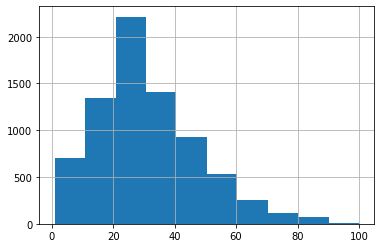

In [33]:
labels.real_age.hist();

We see most of our photos are in age range of 10 to 50, with the peak being between 20 and 40

Printing 15 photos of different ages from the dataset:

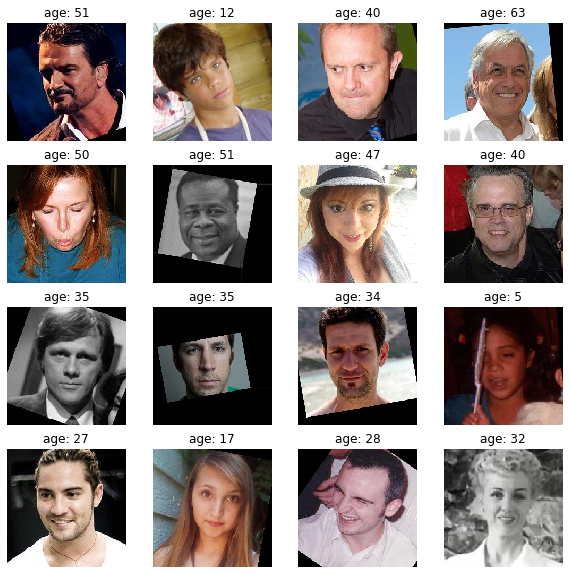

In [79]:
fig, axes = plt.subplots(4,4, figsize=(10,10))
x,y = datagen_flow.next()

for i in range(16):
    a,b = i//4, i%4
    image = x[i]
    label = y[i]
    axes[a,b].set_title(f'age: {label}')
    axes[a,b].imshow(image)
    axes[a,b].set_axis_off()

### Findings

- We have 97 different ages in our dataset
- Most of the pictures age are distributed between the ages of 20 to 50
- some pictures are rotated, or croped in a way.

## Modelling

Defining the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    """
    It loads the train part of dataset from path
    """
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1.0 / 255
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345,
    )
    return train_gen_flow

In [ ]:
def load_test(path):
    """
    It loads the validation/test part of dataset from path
    """
    test_datagen = ImageDataGenerator(
        validation_split=0.25, rescale=1.0 / 255
    )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + "labels.csv"),
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345,
    )
    return test_gen_flow

In [ ]:
def create_model(input_shape=(224, 224, 3)):
    """
    It defines the model
    """
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    return model

In [80]:
def train_model(model,
                train_data,
                test_data,
                batch_size=None, epochs=19,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

### Prepare the Script to Run on the GPU Platform

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Placing the output from the GPU platform as an Markdown cell here.

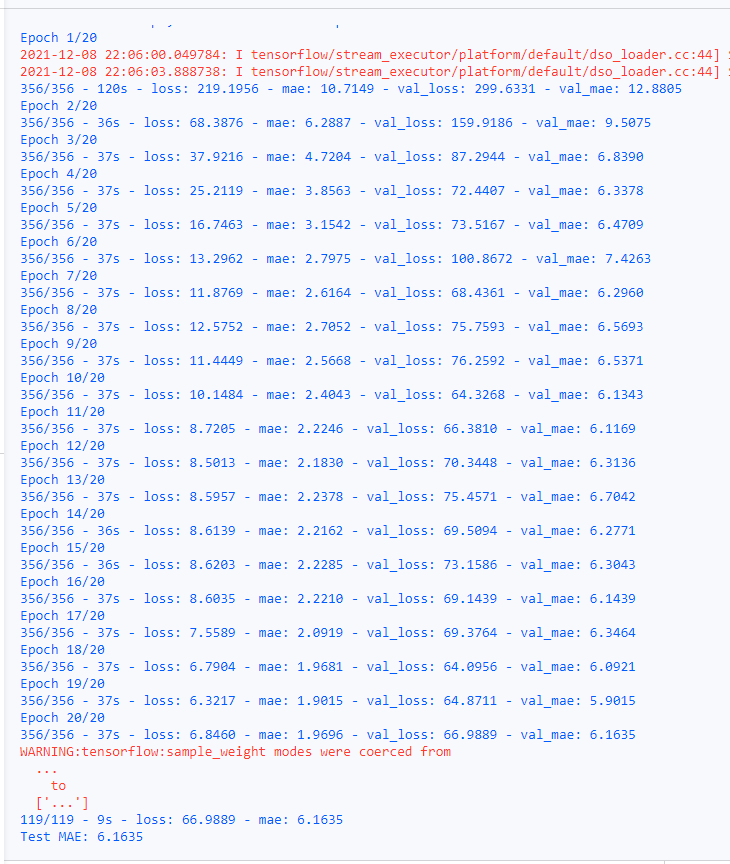

## Conclusions

- We have used ResNet50 as a backbone for our model
- We can see our lowest MAE on the test set was achieved at the 19th epoch - with value of 5.9015, which is not higher than the threshold of 8 for this task.
- We have chosen learning rate of 0.0001 after various tests.